# Libraries

In [1]:
import psutil
psutil.virtual_memory() 

svmem(total=540408950784, available=502938206208, percent=6.9, used=33205100544, free=504287391744, active=1297420288, inactive=26018926592, buffers=4354048, cached=2912104448, shared=1210195968, slab=1262567424)

In [2]:
from datetime import datetime

import numpy as np
import pandas as pd
from numpy import array

from os import listdir
from os.path import isfile, join
import glob

import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#import cmocean
##from mpl_toolkits.basemap import Basemap

from matplotlib import ticker
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from cartopy.mpl.ticker import LongitudeFormatter


import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr
import scipy as _sp

import random

In [3]:
import klus.algorithms as al
# import d3s.domain as domain
import klus.kernels as kernels
# import d3s.tools as tools

import zapata.computation as zcom
import zapata.data as zdat
import zapata.lib as zlib
import zapata.mapping as zmap
import zapata.koopman as zkop

from scipy.spatial import distance

from scipy.signal import argrelextrema
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

#%pdb
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [4]:
import scipy.linalg as sc
import numpy.linalg as lin

# Definition of functions

## Definition order_w

In [ ]:
def order_w(w,option='magnitude',direction='up'):
    '''
    Order Eigenvalues according to 
    option
    'magnitude'         abs(w)
    'frequency'         w.imag
    'growth'            w.real
    'ones'              abs(w) closest to 1.0
    
    direction
    'up'               descending
    'down'             ascending
    
    '''
    print(' Ordering Eigenvalues as ', option, ' with direction ',direction)
    w_cont = np.log(w)
    if option == 'magnitude':
        ind=abs(w).argsort()
    elif option == 'frequency':
        ind=abs(w_cont.imag).argsort()
    elif option == 'growth':
        ind=np.abs(w_cont.real - 0.0).argsort()
    elif option == 'one':
        ind=np.abs(np.abs(w) - 1.0).argsort()
    else:
        print(' Error in oder_w', option, direction)
# Choose direction
    if direction == 'up':
        indu=ind[::-1]
    else:
        indu=ind

    w0=w[indu]
    w1=w_cont[indu]
    return w0,w1,indu


## Definition function evolve and verify

In [ ]:
def evolve(tim_level,tstep,init_date):
    #tim_level=[0,1,2,3,4,5,6]
    #cases =  216,228,240, 36,48,60,  360,372,384
    #tstep=3
    #nstart=360
    x0=PsiX[:,init_date]
    ht=np.zeros([x0.shape[0],len(tim_level)],dtype='complex')
    for j in tim_level:
        D = np.diag(vw_s[:nmode]**(j*tstep))                  # w --> vw_s
        ht[:,j]=alpha@D@vcut.T@Gxx[init_date,:] 
    return ht

#verify to EOF expansion  (spatial correlation)
def verify(tim_level,tstep,init_date,PCs,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        kaz2=PCs[:,int(init_date+neig*tstep)]
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz2, axis=1)
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp[:,0])[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab


#verify to total data
def verify_tot(tim_level,tstep,init_date,X,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = X.A.data[:, int(init_date+neig*tstep)]
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp)[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab

## Definition dates2years

In [ ]:
def date2year(years,init_year,date):
    """Transform index date ['Jan' '1989' ] in index i.
    
    Years are from np.arange(1960,2020, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=float(date[4:8])
    m=mon.index(str(date[0:3]))
    index = (y-init_year)*12 + m
    return int(index)

In [ ]:
def year2date(years,i):
    """ Transform index i in string date yy/mm.
    
    Rounding requires the small shift
    Years are obtained from np.arange(1920,2018, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=str(int(years[i]+0.001))
    m=np.mod(int(round((years[i]-int(years[i]))*12)),12)
    date = mon[m] + ' ' + y
    return date

## Definition eigenvalues on points

In [ ]:
def eigenfunction_value(cc, KK_tot, x, mode ):
    '''
    Compute eigenfunction value at point x

    Parameters
    ----------
    x: Point at which eigenfunction is computed
    mode: Mode number

    Returns
    -------
    eigenfunction value
    '''
    k = KK_tot.ker
    f = 0
    for i in range(KK_tot.ntime):
        f +=  cc[i,mode]*k(x, KK_tot.PsiX[:, i])       #somma per tutti i tempo: componente del modo (colonna) per kernel(initial condition x, fila PsiX)
    return f

In [ ]:
def eigenfunction_value_opt(cc, KK_tot, x, mode):
    '''
    Compute eigenfunction value at point x

    Parameters
    ----------
    x: Point at which eigenfunction is computed
    mode: Mode number

    Returns
    -------
    eigenfunction value
    '''
    k = KK_tot.ker
    ntime = KK_tot.ntime
    PsiX = KK_tot.PsiX
    mode_cc = cc[:, mode]  # Extract the mode component once

    # Precompute k(x, PsiX) to avoid redundant calculations
    k_values = np.array([k(x, PsiX[:, i]) for i in range(ntime)])

    f = np.dot(mode_cc, k_values)  # Use NumPy dot product for summation
    return f

## Definition sigma cost function

In [ ]:
from scipy.optimize import minimize_scalar

In [ ]:
def cost(x):
    ss = str(x)
    KK_tot.fit(bandwidth=ss)
    KMM = sc.pinv(KK_tot.vv)@(KK_tot.PsiX.T)
    return sum(lin.norm(KK_tot.vv@KMM-KK_tot.PsiX.T, axis=0))

# Load and regrid data

In [5]:
#CMIP Jakob
ds_tos = xr.open_dataarray("CESM_data/regridded_tos.nc")
ds_ssh = xr.open_dataarray("CESM_data/regridded_ssh.nc")

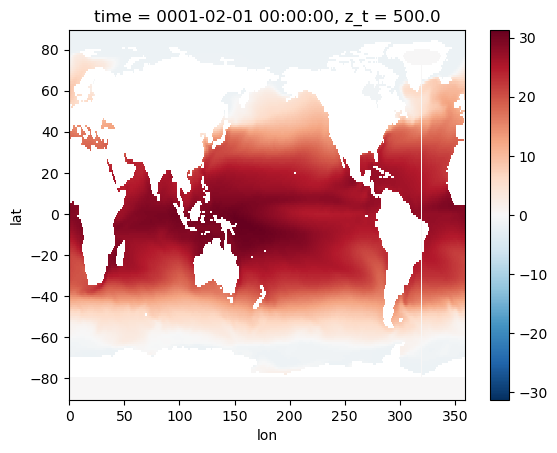

In [6]:
ds_tos.isel(time=0).plot()

## Subset data

In [7]:
#  Read Variable
area='Jakob'
if area == 'TROPIC':
    # central pacific coordinates
    arealat=(35,-35)
    arealon=[-180, 180.]
elif area == 'GLOBAL':
    arealat=(60,-60)
    arealon=[-160,110.]
elif area == 'WORLD':
    arealat=(60,-60)
    arealon=[-180,180.]
elif area == 'NAVARRA_2021':
    arealat=(-15,15)
    arealon=[140,290.]
elif area == 'Jakob':
    arealat=(-31,32)
    arealon=[130,290.]
else:
    Print(f'No area ')
    
case = 'UNIT'    
data_name= 'CESM'
variable='SST'
lev = 'SURF'
shift = 'ERA5'
period = 'ANN'
normalization = 'anom'

# Use SVD encoding
encode_svd = True
#Choose number of SVD to ratain
var_retained = None #None# Variance retained or None for full rank
#Option to write files
write_files = False

In [8]:
S_tos = ds_tos.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))
S_ssh = ds_ssh.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))

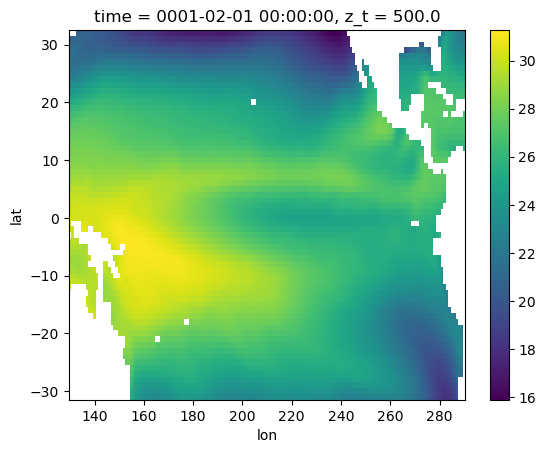

In [9]:
S_tos.isel(time=0).plot()

In [10]:
del(ds_tos, ds_ssh)

In [11]:
import psutil
psutil.virtual_memory() 

svmem(total=540408950784, available=525694259200, percent=2.7, used=10695860224, free=527228932096, active=1140531200, inactive=3482062848, buffers=4354048, cached=2479804416, shared=1059495936, slab=1210843136)

## Create matrices, de-trending data and anomalies

In [12]:
#Create Xmats
X_tos=zcom.Xmat(S_tos,dims=('lat','lon'))
X_tos.A = X_tos.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [13]:
X_ssh=zcom.Xmat(S_ssh,dims=('lat','lon'))
X_ssh.A = X_ssh.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [14]:
del(S_tos,S_ssh)

In [15]:
#Detrending
X_tos.detrend(axis=1)
X_ssh.detrend(axis=1)

Detrending data with options -->  {'axis': 1}
Detrending data with options -->  {'axis': 1}


In [16]:
#Anomalies
X_tos.anom(option='anomstd',freq='month')
X_ssh.anom(option='anomstd',freq='month')

In [17]:
del(X_ssh)

# Evaluation

### Tools for the plots

In [5]:
import nc_time_axis

In [6]:
flabel = {'fontsize':14,'fontweight':'bold'}   #,'fontfamily':'Futura'
ftitle = {'fontsize':18,'fontweight':'bold'}   #,'fontfamily':'Futura',

In [7]:
from pylab import *

cmap = cm.get_cmap('plasma', 19)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

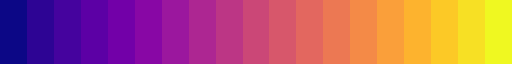

In [8]:
cmap   # First forecasts purple,    last forecasts yellow

### Data preparation

In [9]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [10]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
operators=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

## ALL GAUSS

In [11]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [12]:
#Vector with all correlations (First ensemble then member)
ALLGAUSS_corr_tot=np.zeros((24,20,2))

In [13]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

NameError: name 'X_tos' is not defined

### Load data

In [27]:
tot_for=np.zeros((20, 19, 1845, 24, 1176))

In [28]:
for n in range(len(operators)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 100/ALLEOFs_forecast_p{n}.npy')

In [29]:
tot_for_union=np.empty((19, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

In [30]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]


In [31]:
del(tot_for)

In [32]:
import psutil
psutil.virtual_memory()

svmem(total=540408950784, available=361379577856, percent=33.1, used=175009898496, free=362913558528, active=1142042624, inactive=167475621888, buffers=4354048, cached=2481139712, shared=1059495936, slab=1212215296)

### Correlations

In [33]:
mean_av=np.zeros(24)

In [34]:
import random

In [37]:
diff_gaussALL_lead=np.zeros((19,5))
lead=5


for m in range(5):

    for i in for_levels:
        
        num=i+1
    
        mean_av=np.zeros(24)
        mean_ind=np.zeros((24,num))
        
        chosen=random.sample(for_levels, k=num)
        tot_for_union_sel=tot_for_union[chosen, :,:,:]
        
        ## Compute average forecast
        av_for=np.mean(tot_for_union_sel, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
        av_for_geo = xr.full_like(X_tos.A[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
        
        #Correlation average forecast and observations
        mean_av[lead]=np.corrcoef(Xindex[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        #RMSE_mean_av[lead]=1-np.sqrt(np.square(np.subtract(Xindex[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex[np.invert(np.isnan(Avindex))])
        #print(mean_av[lead])
        
        #Average correlation between individual forecast and observations
        for i in range(num):  
            phix_geo_array=udat_sst @ tot_for_union_sel[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos.A[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
        
            mean_ind[lead,i]=np.corrcoef(Xindex[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            #RMSE_mean_ind[lead,i]= 1-np.sqrt(np.square(np.subtract(Xindex[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind, axis=1)[lead]
        diff_gaussALL_lead[i,m]=mean_av[lead]-av_corr
        print(m, " ", num, "   ", mean_av[lead]-av_corr)

0   1     0.0
0   2     0.01563591151669086
0   3     0.022085995108191314
0   4     0.0247603524419302
0   5     0.03153939935598882
0   6     0.0302874197858638
0   7     0.027512911795706696
0   8     0.03068759346955663
0   9     0.03064778689605685
0   10     0.03234055393265045
0   11     0.03145414610485431


KeyboardInterrupt: 

In [ ]:
np.save('Forecasts/Skill metrics/diff_gaussALL_lead5_1.npy', diff_gaussALL_lead, allow_pickle=True, fix_imports=True)

In [ ]:
np.save('Forecasts/Skill metrics/diff_gaussALL_lead10_1.npy', diff_gaussALL_lead, allow_pickle=True, fix_imports=True)

In [ ]:
np.save('Forecasts/Skill metrics/diff_gaussALL_lead15_1.npy', diff_gaussALL_lead, allow_pickle=True, fix_imports=True)

## 30 GAUSS

In [71]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [72]:
#Vector with all correlations (First ensemble then member)
GAUSS_corr_tot=np.zeros((24,20,2))

In [73]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

### Load data

In [74]:
tot_for=np.zeros((20, 19, 30, 24, 1176))

In [77]:
for n in range(len(operators)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 100/30EOFs_forecast_p{n}.npy')

In [78]:
tot_for_union=np.empty((19, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [79]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]


In [80]:
del(tot_for)

### Correlations

In [81]:
mean_av=np.zeros(24)

In [82]:
import random

In [83]:
diff_gauss30_lead=np.zeros((19,5))
lead=5


for m in range(5):

    for i in for_levels:
        
        num=i+1
    
        mean_av=np.zeros(24)
        mean_ind=np.zeros((24,num))
        
        chosen=random.sample(for_levels, k=num)
        tot_for_union_sel=tot_for_union[chosen, :,:,:]
        
        ## Compute average forecast
        av_for=np.mean(tot_for_union_sel, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos.A[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
        
        #Correlation average forecast and observations
        mean_av[lead]=np.corrcoef(Xindex[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        #RMSE_mean_av[lead]=1-np.sqrt(np.square(np.subtract(Xindex[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex[np.invert(np.isnan(Avindex))])
        #print(mean_av[lead])
        
        #Average correlation between individual forecast and observations
        for i in range(num):  
            phix_geo_array=udat_sst @ tot_for_union_sel[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos.A[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
        
            mean_ind[lead,i]=np.corrcoef(Xindex[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            #RMSE_mean_ind[lead,i]= 1-np.sqrt(np.square(np.subtract(Xindex[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind, axis=1)[lead]
        diff_gauss30_lead[i,m]=mean_av[lead]-av_corr
        print(m, " ", num, "   ", mean_av[lead]-av_corr)

0   1     0.0
0   2     0.03596067210127829
0   3     0.05415323474211153
0   4     0.06175271267373783
0   5     0.07220901269075153
0   6     0.07390493618234106
0   7     0.07112754029844526
0   8     0.07304027115277989
0   9     0.08091897074306686
0   10     0.08114092496410064
0   11     0.07830485405582988
0   12     0.08075605379887829
0   13     0.08099059301456146
0   14     0.08307231703908047
0   15     0.08241075621740701
0   16     0.08537245693885465
0   17     0.08247611800427024
0   18     0.08378955834750668
0   19     0.08419436580028106
1   1     0.0
1   2     0.04290464943000738
1   3     0.0563628155489001
1   4     0.06345714802493296
1   5     0.07020284645251174
1   6     0.07237097120428182
1   7     0.07698655074629501
1   8     0.08043074811313533
1   9     0.07722667390768734
1   10     0.08229532284563146
1   11     0.08090584423380531
1   12     0.08030084116718916
1   13     0.08241668417711023
1   14     0.0812161765706324
1   15     0.0833573154666487

In [85]:
np.save('Forecasts 100/Skill metrics/diff_gauss30_lead5_2.npy', diff_gauss30_lead, allow_pickle=True, fix_imports=True)

In [ ]:
np.save('Forecasts/Skill metrics/diff_gauss30_lead10_1.npy', diff_gauss30_lead, allow_pickle=True, fix_imports=True)

In [ ]:
np.save('Forecasts/Skill metrics/diff_gauss30_lead15_1.npy', diff_gauss30_lead, allow_pickle=True, fix_imports=True)

## 30 POLY

In [ ]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [ ]:
#Vector with all correlations (First ensemble then member)
GAUSS_corr_tot=np.zeros((24,20,2))

In [ ]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

### Load data

In [ ]:
tot_for=np.zeros((20, 19, 30, 24, 1176))

In [ ]:
for n in range(len(operators)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts/Poly_forecast_p{n}.npy')

In [ ]:
tot_for_union=np.empty((19, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [ ]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]


In [ ]:
del(tot_for)

### Correlations

In [ ]:
mean_av=np.zeros(24)

In [ ]:
import random

In [ ]:
diff_poly_lead=np.zeros((19,5))
lead=15


for m in range(5):

    for i in for_levels:
        
        num=i+1
    
        mean_av=np.zeros(24)
        mean_ind=np.zeros((24,num))
        
        chosen=random.sample(for_levels, k=num)
        tot_for_union_sel=tot_for_union[chosen, :,:,:]
        
        ## Compute average forecast
        av_for=np.mean(tot_for_union_sel, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos.A[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
        
        #Correlation average forecast and observations
        mean_av[lead]=np.corrcoef(Xindex[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        #RMSE_mean_av[lead]=1-np.sqrt(np.square(np.subtract(Xindex[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex[np.invert(np.isnan(Avindex))])
        #print(mean_av[lead])
        
        #Average correlation between individual forecast and observations
        for i in range(num):  
            phix_geo_array=udat_sst @ tot_for_union_sel[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos.A[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
        
            mean_ind[lead,i]=np.corrcoef(Xindex[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            #RMSE_mean_ind[lead,i]= 1-np.sqrt(np.square(np.subtract(Xindex[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind, axis=1)[lead]
        diff_poly_lead[i,m]=mean_av[lead]-av_corr
        print(m, " ", num, "   ", mean_av[lead]-av_corr)

In [ ]:
np.save('Forecasts/Skill metrics/diff_poly_lead5_1.npy', diff_poly_lead, allow_pickle=True, fix_imports=True)

In [ ]:
np.save('Forecasts/Skill metrics/diff_poly_lead10_1.npy', diff_poly_lead, allow_pickle=True, fix_imports=True)

In [ ]:
np.save('Forecasts/Skill metrics/diff_poly_lead15_1.npy', diff_poly_lead, allow_pickle=True, fix_imports=True)

# TOT GRAPH

In [14]:
diff_gauss30_lead5=np.load('Forecasts 100/Skill metrics/diff_gauss30_lead5.npy')
diff_gauss30_lead10=np.load('Forecasts 100/Skill metrics/diff_gauss30_lead10.npy')
diff_gauss30_lead15=np.load('Forecasts 100/Skill metrics/diff_gauss30_lead15.npy')

In [15]:
diff_gauss30_lead5_1=np.load('Forecasts 100/Skill metrics/diff_gauss30_lead5_1.npy')
diff_gauss30_lead10_1=np.load('Forecasts 100/Skill metrics/diff_gauss30_lead10_1.npy')
diff_gauss30_lead15_1=np.load('Forecasts 100/Skill metrics/diff_gauss30_lead15_1.npy') 

In [16]:
diff_gaussALL_lead5=np.load('Forecasts 100/Skill metrics/diff_gaussALL_lead5.npy')
diff_gaussALL_lead10=np.load('Forecasts 100/Skill metrics/diff_gaussALL_lead10.npy')
diff_gaussALL_lead15=np.load('Forecasts 100/Skill metrics/diff_gaussALL_lead15.npy')

In [17]:
diff_gaussALL_lead5_1=np.load('Forecasts 100/Skill metrics/diff_gaussALL_lead5_1.npy' )
diff_gaussALL_lead10_1=np.load('Forecasts 100/Skill metrics/diff_gaussALL_lead10_1.npy')
diff_gaussALL_lead15_1=np.load('Forecasts 100/Skill metrics/diff_gaussALL_lead15_1.npy')

In [18]:
diff_poly_lead5=np.load('Forecasts 100/Skill metrics/diff_poly_lead5.npy')
diff_poly_lead10=np.load('Forecasts 100/Skill metrics/diff_poly_lead10.npy')
diff_poly_lead15=np.load('Forecasts 100/Skill metrics/diff_poly_lead15.npy')

In [19]:
diff_poly_lead5_1=np.load('Forecasts 100/Skill metrics/diff_poly_lead5_1.npy') 
diff_poly_lead10_1=np.load('Forecasts 100/Skill metrics/diff_poly_lead10_1.npy')
diff_poly_lead15_1=np.load('Forecasts 100/Skill metrics/diff_poly_lead15_1.npy')

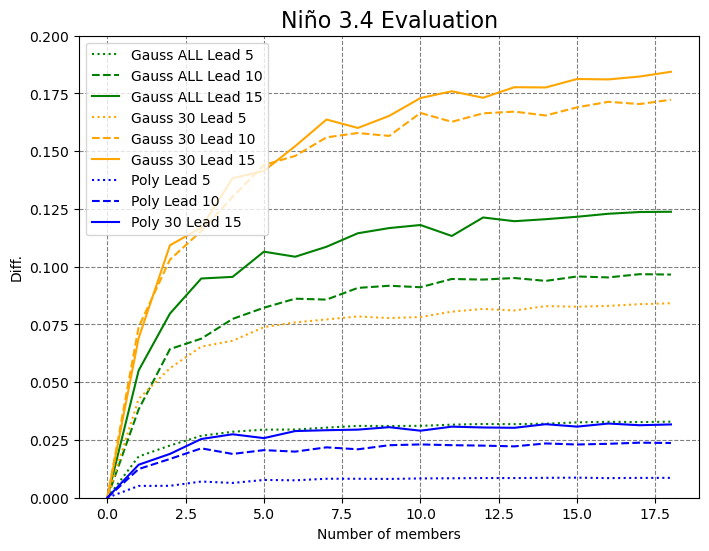

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))

xval=range(0,19)

ax.axhline(0.6, linestyle='--',color='black')
ax.set_xlabel('Number of members')
ax.set_ylabel('Diff.')
ax.set_ylim([0,0.2])
ax.set_title('',loc='left')

ax.plot(xval, np.mean(diff_gaussALL_lead5, axis=1), lw=1.5, label='Gauss ALL Lead 5', linestyle='dotted', color='green')
ax.plot(xval, np.mean(diff_gaussALL_lead10, axis=1), lw=1.5, label='Gauss ALL Lead 10', linestyle='dashed', color='green')
ax.plot(xval, np.mean(diff_gaussALL_lead15, axis=1), lw=1.5, label='Gauss ALL Lead 15', color='green')

ax.plot(xval, np.mean(diff_gauss30_lead5, axis=1), lw=1.5, label='Gauss 30 Lead 5', linestyle='dotted', color='orange')
ax.plot(xval, np.mean(diff_gauss30_lead10, axis=1), lw=1.5, label='Gauss 30 Lead 10', linestyle='dashed', color='orange')
ax.plot(xval, np.mean(diff_gauss30_lead15, axis=1), lw=1.5, label='Gauss 30 Lead 15', color='orange')

ax.plot(xval, np.mean(diff_poly_lead5, axis=1), lw=1.5, label='Poly Lead 5', linestyle='dotted', color='blue')
ax.plot(xval, np.mean(diff_poly_lead10, axis=1), lw=1.5, label='Poly Lead 10', linestyle='dashed', color='blue')
ax.plot(xval, np.mean(diff_poly_lead15, axis=1), lw=1.5, label='Poly 30 Lead 15', color='blue')



bigtitle = 'Niño 3.4 Evaluation' 
ax.set_title(bigtitle,fontsize=16)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')

plt.legend()
plt.suptitle('',fontsize='xx-large')
labfile = 'due metodi forecasting MONTHS' + '.pdf'
#plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show() 

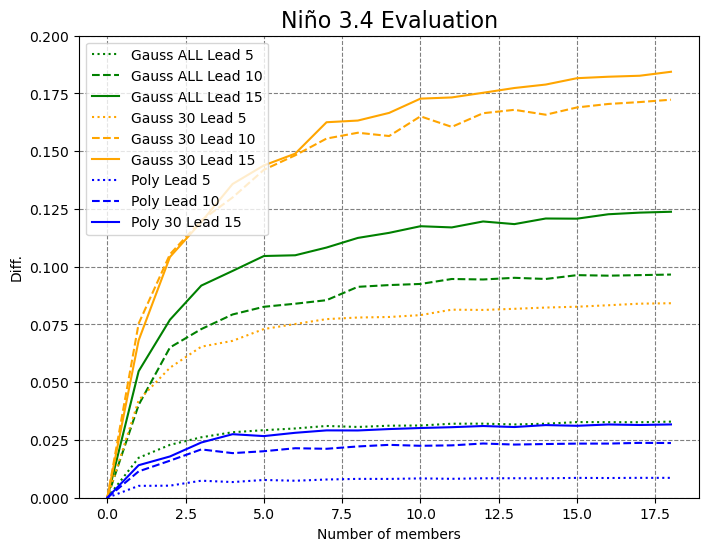

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))

xval=range(0,19)

ax.axhline(0.6, linestyle='--',color='black')
ax.set_xlabel('Number of members')
ax.set_ylabel('Diff.')
ax.set_ylim([0,0.2])
ax.set_title('',loc='left')

ax.plot(xval, np.mean(np.concatenate((diff_gaussALL_lead5, diff_gaussALL_lead5_1), axis=1), axis=1), lw=1.5, label='Gauss ALL Lead 5', linestyle='dotted', color='green')
ax.plot(xval, np.mean(np.concatenate((diff_gaussALL_lead10, diff_gaussALL_lead10_1), axis=1), axis=1), lw=1.5, label='Gauss ALL Lead 10', linestyle='dashed', color='green')
ax.plot(xval, np.mean(np.concatenate((diff_gaussALL_lead15, diff_gaussALL_lead15_1), axis=1), axis=1), lw=1.5, label='Gauss ALL Lead 15', color='green')


ax.plot(xval, np.mean(np.concatenate((diff_gauss30_lead5, diff_gauss30_lead5_1), axis=1), axis=1), lw=1.5, label='Gauss 30 Lead 5', linestyle='dotted', color='orange')
ax.plot(xval, np.mean(np.concatenate((diff_gauss30_lead10, diff_gauss30_lead10_1), axis=1), axis=1), lw=1.5, label='Gauss 30 Lead 10', linestyle='dashed', color='orange')
ax.plot(xval, np.mean(np.concatenate((diff_gauss30_lead15, diff_gauss30_lead15_1), axis=1), axis=1), lw=1.5, label='Gauss 30 Lead 15', color='orange')

ax.plot(xval, np.mean(np.concatenate((diff_poly_lead5, diff_poly_lead5_1), axis=1), axis=1), lw=1.5, label='Poly Lead 5', linestyle='dotted', color='blue')
ax.plot(xval, np.mean(np.concatenate((diff_poly_lead10, diff_poly_lead10_1), axis=1), axis=1), lw=1.5, label='Poly Lead 10', linestyle='dashed', color='blue')
ax.plot(xval, np.mean(np.concatenate((diff_poly_lead15, diff_poly_lead15_1), axis=1), axis=1), lw=1.5, label='Poly 30 Lead 15', color='blue')



bigtitle = 'Niño 3.4 Evaluation' 
ax.set_title(bigtitle,fontsize=16)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')

plt.legend()
plt.suptitle('',fontsize='xx-large')
labfile = 'due metodi forecasting MONTHS' + '.pdf'
#plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show() 